In [2]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from lightgbm import LGBMClassifier
from kuma_utils.stats import PropensityScoreMatching, make_demographic_table
from kuma_utils.preprocessing import PrepPipeline, SelectCategorical, SelectNumerical, DummyVarible, DistTransformer, Cast

In [3]:
from catboost.datasets import adult
train, test = adult()
full_dataset = pd.concat([train.assign(group='train'), test.assign(group='test')], axis=0)

# Make demopgraphic table (a.k.a. Table 1)
for numeric variables:
- run KS test
    - if the varible follows normal distribution, run T test
    - if no, run Mann Whitney U test
    
for categorical variables:
- run chi-squared test

In [4]:
full_dataset = full_dataset[
    ['occupation', 'education', 'age', 'sex', 'fnlwgt', 'capital-loss', 'group']].copy().sample(10000)  # To make it simple

In [5]:
make_demographic_table(full_dataset, group_col='group', display_cols=full_dataset.columns)

,_item,_type,_ks_stat,_stat_test,_nan_info,train,test,p-value
0,N,numerical,NaN,None,False,6636,3364,NaN
1,"occupation=Adm-clerical, n(%)",categorical,NaN,Chi2,False,771 (11.6%),326 (9.7%),0.003972
2,"occupation=Armed-Forces, n(%)",categorical,NaN,Chi2,False,4 (0.1%),0 (0.0%),0.370768
3,"occupation=Craft-repair, n(%)",categorical,NaN,Chi2,False,787 (11.9%),437 (13.0%),0.110031
4,"occupation=Exec-managerial, n(%)",categorical,NaN,Chi2,False,852 (12.8%),437 (13.0%),0.855635
5,"occupation=Farming-fishing, n(%)",categorical,NaN,Chi2,False,197 (3.0%),87 (2.6%),0.305788
6,"occupation=Handlers-cleaners, n(%)",categorical,NaN,Chi2,False,265 (4.0%),152 (4.5%),0.234809
7,"occupation=Machine-op-inspct, n(%)",categorical,NaN,Chi2,False,406 (6.1%),203 (6.0%),0.903663
8,"occupation=NaN, n(%)",categorical,NaN,Chi2,True,365 (5.5%),178 (5.3%),0.697257
9,"occupation=Other-service, n(%)",categorical,NaN,Chi2,False,664 (10.0%),333 (9.9%),0.893739


# Propensity score matching
Matching methods
- Greedy: very slow / more matched pairs
- Hungarian algorithm: very fast / slightly less pairs

In [6]:
psm_greedy = PropensityScoreMatching(
    match_cols=['occupation', 'education', 'age', 'sex', 'fnlwgt', 'capital-loss'], 
    group_col='group', 
    categorical_encoder=PrepPipeline([SelectCategorical(), DummyVarible(dummy_na=True)]),
    numerical_encoder=PrepPipeline([SelectNumerical(), DistTransformer('standard')]),
    matching_method='greedy')
make_demographic_table(
    psm_greedy.run(full_dataset), group_col='group', display_cols=full_dataset.columns) #  ~60s

Logger created at 24/02/13:05:37:05
eval_metric automatically selected.
05:37:05 [None]	best score is 0.538346


,_item,_type,_ks_stat,_stat_test,_nan_info,test,train,p-value
0,N,numerical,NaN,None,False,3352,3352,NaN
1,"occupation=Adm-clerical, n(%)",categorical,NaN,Chi2,False,326 (9.7%),322 (9.6%),0.901318
2,"occupation=Armed-Forces, n(%)",categorical,NaN,Chi2,False,0 (0.0%),1 (0.0%),1.000000
3,"occupation=Craft-repair, n(%)",categorical,NaN,Chi2,False,437 (13.0%),409 (12.2%),0.320686
4,"occupation=Exec-managerial, n(%)",categorical,NaN,Chi2,False,437 (13.0%),449 (13.4%),0.691593
5,"occupation=Farming-fishing, n(%)",categorical,NaN,Chi2,False,87 (2.6%),76 (2.3%),0.427801
6,"occupation=Handlers-cleaners, n(%)",categorical,NaN,Chi2,False,151 (4.5%),161 (4.8%),0.601801
7,"occupation=Machine-op-inspct, n(%)",categorical,NaN,Chi2,False,203 (6.1%),189 (5.6%),0.498609
8,"occupation=NaN, n(%)",categorical,NaN,Chi2,True,178 (5.3%),174 (5.2%),0.869518
9,"occupation=Other-service, n(%)",categorical,NaN,Chi2,False,333 (9.9%),334 (10.0%),1.000000


In [7]:
psm_fast = PropensityScoreMatching(
    match_cols=['occupation', 'education', 'age', 'sex', 'fnlwgt', 'capital-loss'],
    group_col='group', 
    categorical_encoder=PrepPipeline([SelectCategorical(), DummyVarible(dummy_na=True)]),
    numerical_encoder=PrepPipeline([SelectNumerical(), DistTransformer('standard')]),
    matching_method='hungarian')
make_demographic_table(
    psm_fast.run(full_dataset), group_col='group', display_cols=full_dataset.columns)  # ~0.5s

Logger created at 24/02/13:05:38:03
eval_metric automatically selected.
05:38:03 [None]	best score is 0.538346


,_item,_type,_ks_stat,_stat_test,_nan_info,test,train,p-value
0,N,numerical,NaN,None,False,3341,3341,NaN
1,"occupation=Adm-clerical, n(%)",categorical,NaN,Chi2,False,326 (9.8%),321 (9.6%),0.868573
2,"occupation=Armed-Forces, n(%)",categorical,NaN,Chi2,False,0 (0.0%),1 (0.0%),1.000000
3,"occupation=Craft-repair, n(%)",categorical,NaN,Chi2,False,433 (13.0%),404 (12.1%),0.300762
4,"occupation=Exec-managerial, n(%)",categorical,NaN,Chi2,False,437 (13.1%),451 (13.5%),0.639434
5,"occupation=Farming-fishing, n(%)",categorical,NaN,Chi2,False,87 (2.6%),76 (2.3%),0.427782
6,"occupation=Handlers-cleaners, n(%)",categorical,NaN,Chi2,False,150 (4.5%),161 (4.8%),0.561427
7,"occupation=Machine-op-inspct, n(%)",categorical,NaN,Chi2,False,203 (6.1%),189 (5.7%),0.498565
8,"occupation=NaN, n(%)",categorical,NaN,Chi2,True,178 (5.3%),168 (5.0%),0.619275
9,"occupation=Other-service, n(%)",categorical,NaN,Chi2,False,333 (10.0%),335 (10.0%),0.967469


# Feature importances for PSM model


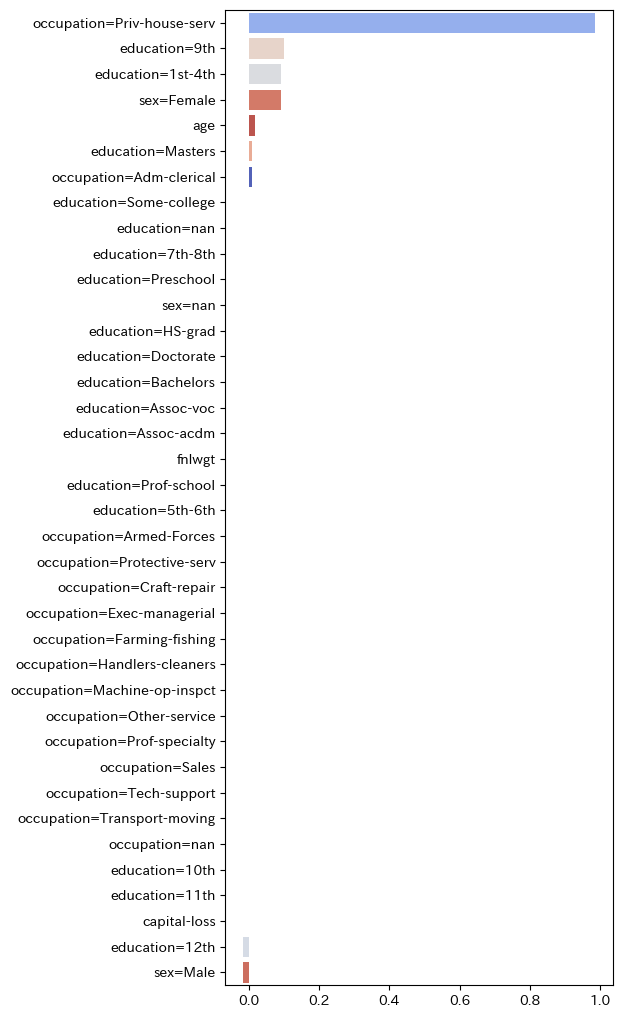

In [8]:
psm_fast.plot_feature_importance(full_dataset)

# PSM with GBDT

In [9]:
psm_lgb = PropensityScoreMatching(
    match_cols=['occupation', 'education', 'age', 'sex', 'fnlwgt', 'capital-loss'],
    group_col='group', 
    categorical_encoder=PrepPipeline([SelectCategorical(), OrdinalEncoder()]),
    numerical_encoder=PrepPipeline([SelectNumerical()]),
    model=LGBMClassifier,
    trainer_params={
        'params': {
            'objective': 'binary',
            'metric': 'auc',
            'verbosity': 0,
        },
        'fit_params': {
            'num_boost_round': 500,
            'callbacks': [lgb.early_stopping(stopping_rounds=50, verbose=True), lgb.log_evaluation(25)]
        }
    },
    fit_method='cv',
    matching_method='hungarian')
make_demographic_table(
    psm_lgb.run(full_dataset.sample(10000)), group_col='group', display_cols=full_dataset.columns)  # ~10s

Logger created at 24/02/13:05:38:05
Training until validation scores don't improve for 50 rounds
[25]	cv_agg's valid auc: 0.502862 + 0.00780258
[50]	cv_agg's valid auc: 0.502438 + 0.00758094
Early stopping, best iteration is:
[6]	cv_agg's valid auc: 0.509516 + 0.0111733
05:38:06 [6]	best score is 0.509516


,_item,_type,_ks_stat,_stat_test,_nan_info,test,train,p-value
0,N,numerical,NaN,None,False,3094,3094,NaN
1,"occupation=Adm-clerical, n(%)",categorical,NaN,Chi2,False,319 (10.3%),225 (7.3%),0.000030
2,"occupation=Armed-Forces, n(%)",categorical,NaN,Chi2,False,0 (0.0%),1 (0.0%),1.000000
3,"occupation=Craft-repair, n(%)",categorical,NaN,Chi2,False,388 (12.5%),408 (13.2%),0.470642
4,"occupation=Exec-managerial, n(%)",categorical,NaN,Chi2,False,396 (12.8%),396 (12.8%),1.000000
5,"occupation=Farming-fishing, n(%)",categorical,NaN,Chi2,False,80 (2.6%),81 (2.6%),1.000000
6,"occupation=Handlers-cleaners, n(%)",categorical,NaN,Chi2,False,138 (4.5%),134 (4.3%),0.852416
7,"occupation=Machine-op-inspct, n(%)",categorical,NaN,Chi2,False,185 (6.0%),211 (6.8%),0.194104
8,"occupation=NaN, n(%)",categorical,NaN,Chi2,True,168 (5.4%),140 (4.5%),0.114509
9,"occupation=Other-service, n(%)",categorical,NaN,Chi2,False,296 (9.6%),314 (10.1%),0.468471
